## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp025'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

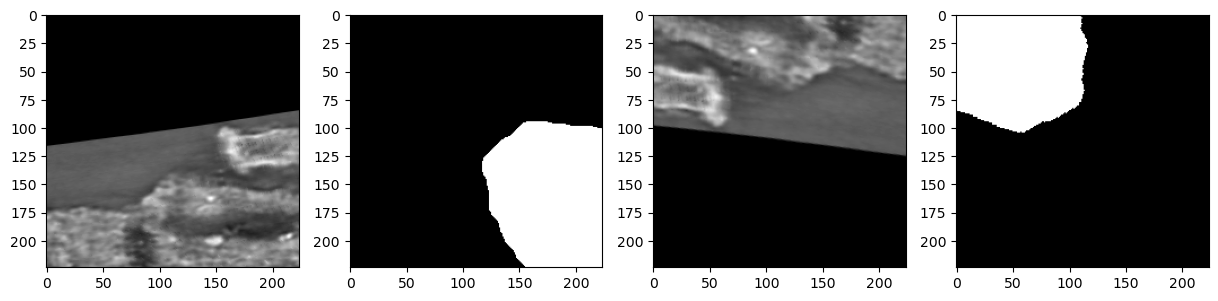

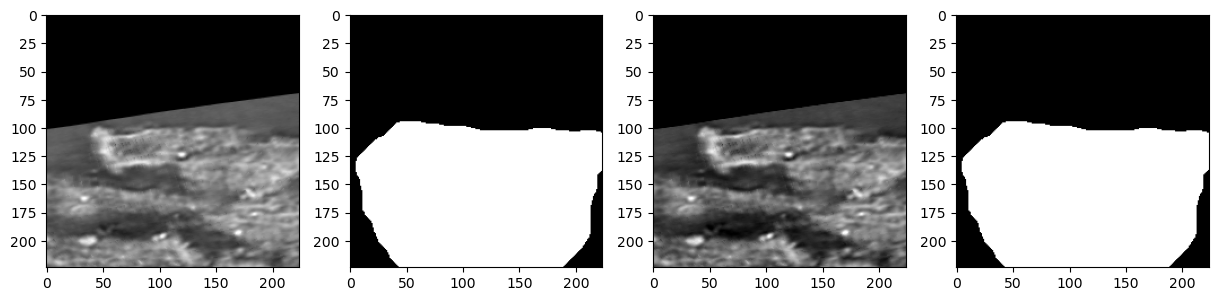

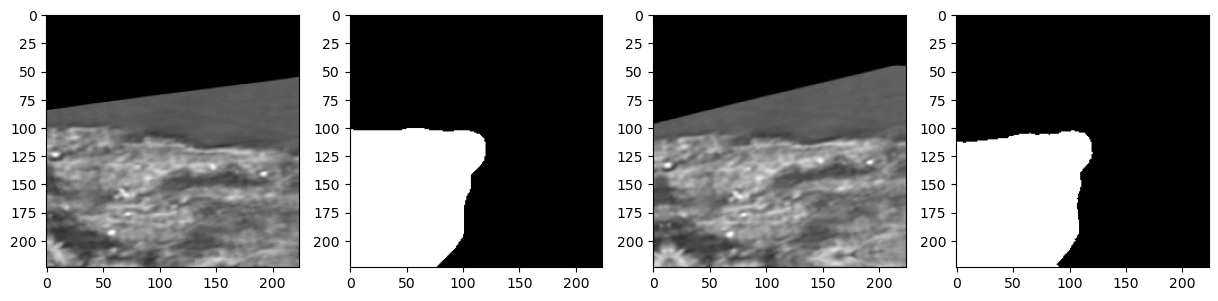

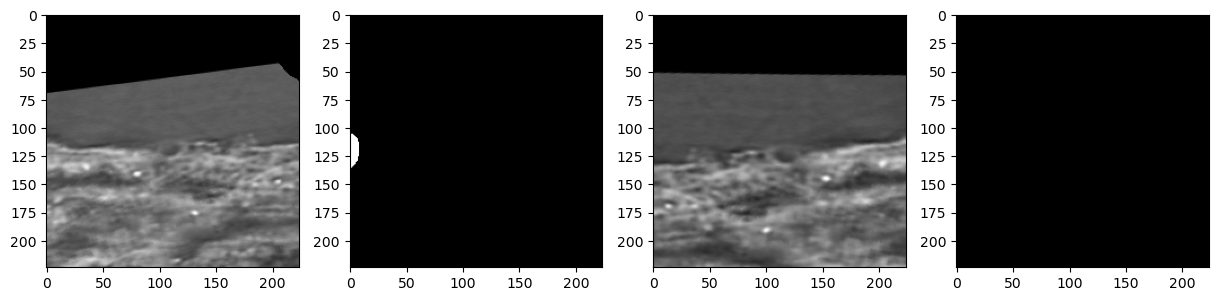

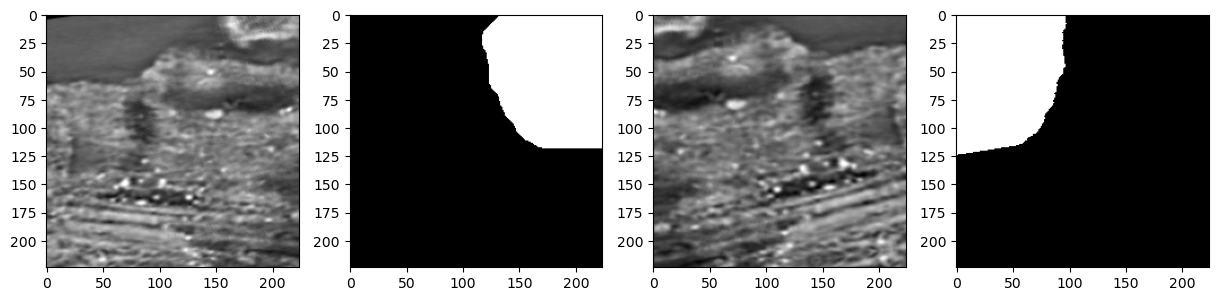

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14169141160028015
th: 0.15, fbeta: 0.14165502493623444
th: 0.2, fbeta: 0.14149856162925423
th: 0.25, fbeta: 0.1418346334149644
th: 0.3, fbeta: 0.19460936682748445
th: 0.35, fbeta: 0.2134732782940103
th: 0.4, fbeta: 0.22673371015496752
th: 0.45, fbeta: 0.23815014430395573


best_th: 0.45, fbeta: 0.23815014430395573
Epoch 1 - avg_train_loss: 0.6733  avg_val_loss: 0.5098  time: 115s
Epoch 1 - avgScore: 0.2382
Epoch 1 - Save Best Score: 0.2382 Model
Epoch 1 - Save Best Loss: 0.5098 Model


th: 0.5, fbeta: 0.23743963298044127


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14170000350114262
th: 0.15, fbeta: 0.14169723411597776
th: 0.2, fbeta: 0.14332810057766887
th: 0.25, fbeta: 0.20069934190929092
th: 0.3, fbeta: 0.23086363779802743
th: 0.35, fbeta: 0.25913756272474137
th: 0.4, fbeta: 0.2616763083839803
th: 0.45, fbeta: 0.22341863479564597


best_th: 0.4, fbeta: 0.2616763083839803
Epoch 2 - avg_train_loss: 0.4706  avg_val_loss: 0.4248  time: 118s
Epoch 2 - avgScore: 0.2617
Epoch 2 - Save Best Score: 0.2617 Model
Epoch 2 - Save Best Loss: 0.4248 Model


th: 0.5, fbeta: 0.17261800335192948


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.34179285803868603
th: 0.15, fbeta: 0.3260459032373808
th: 0.2, fbeta: 0.2783119850932753
th: 0.25, fbeta: 0.23303070749804747
th: 0.3, fbeta: 0.19541649842644837
th: 0.35, fbeta: 0.15686299848325216
th: 0.4, fbeta: 0.12460405986734603
th: 0.45, fbeta: 0.09698788989425113


best_th: 0.1, fbeta: 0.34179285803868603
Epoch 3 - avg_train_loss: 0.2914  avg_val_loss: 0.3405  time: 120s
Epoch 3 - avgScore: 0.3418
Epoch 3 - Save Best Score: 0.3418 Model
Epoch 3 - Save Best Loss: 0.3405 Model


th: 0.5, fbeta: 0.07319851033505924


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2545055330374627
th: 0.15, fbeta: 0.16351382726026012
th: 0.2, fbeta: 0.09532783867056728
th: 0.25, fbeta: 0.05065463525396174
th: 0.3, fbeta: 0.02427614031672978
th: 0.35, fbeta: 0.009910931827403957
th: 0.4, fbeta: 0.004938905688328563
th: 0.45, fbeta: 0.0025301462539665215


best_th: 0.1, fbeta: 0.2545055330374627
Epoch 4 - avg_train_loss: 0.2118  avg_val_loss: 0.3849  time: 118s
Epoch 4 - avgScore: 0.2545


th: 0.5, fbeta: 0.0012145089561415988


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23448822351030274
th: 0.15, fbeta: 0.12226998523931482
th: 0.2, fbeta: 0.0728765086030816
th: 0.25, fbeta: 0.04887238905843729
th: 0.3, fbeta: 0.034344307644025504
th: 0.35, fbeta: 0.0260503530937867
th: 0.4, fbeta: 0.020659268422342163
th: 0.45, fbeta: 0.016661494184646887


best_th: 0.1, fbeta: 0.23448822351030274
Epoch 5 - avg_train_loss: 0.1930  avg_val_loss: 0.4472  time: 116s
Epoch 5 - avgScore: 0.2345


th: 0.5, fbeta: 0.013367022506070886


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22490765086459102
th: 0.15, fbeta: 0.1334548417378372
th: 0.2, fbeta: 0.0901974062835462
th: 0.25, fbeta: 0.06429905377378897
th: 0.3, fbeta: 0.04387369703670108
th: 0.35, fbeta: 0.03007553564388676
th: 0.4, fbeta: 0.02149937303265545
th: 0.45, fbeta: 0.015168226804457148


best_th: 0.1, fbeta: 0.22490765086459102
Epoch 6 - avg_train_loss: 0.1803  avg_val_loss: 0.4492  time: 116s
Epoch 6 - avgScore: 0.2249


th: 0.5, fbeta: 0.01015344783853879


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40539602023574056
th: 0.15, fbeta: 0.4111155536102868
th: 0.2, fbeta: 0.3893577965139179
th: 0.25, fbeta: 0.3596605975776403
th: 0.3, fbeta: 0.3244827205181233
th: 0.35, fbeta: 0.2872623189914442
th: 0.4, fbeta: 0.2486300237662132
th: 0.45, fbeta: 0.21176585971403356


best_th: 0.15, fbeta: 0.4111155536102868
Epoch 7 - avg_train_loss: 0.1716  avg_val_loss: 0.4140  time: 117s
Epoch 7 - avgScore: 0.4111
Epoch 7 - Save Best Score: 0.4111 Model
Epoch 7 - Save Best Loss: 0.4140 Model


th: 0.5, fbeta: 0.1770908735107949


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3603420653835758
th: 0.15, fbeta: 0.3439472557845179
th: 0.2, fbeta: 0.3143001200855215
th: 0.25, fbeta: 0.2821748550345444
th: 0.3, fbeta: 0.2442580171425285
th: 0.35, fbeta: 0.2044500710670594
th: 0.4, fbeta: 0.16689740637320738
th: 0.45, fbeta: 0.1349452534724915


best_th: 0.1, fbeta: 0.3603420653835758
Epoch 8 - avg_train_loss: 0.1602  avg_val_loss: 0.4618  time: 120s
Epoch 8 - avgScore: 0.3603


th: 0.5, fbeta: 0.10129443113442238


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3852285613562525
th: 0.15, fbeta: 0.38859023221644057
th: 0.2, fbeta: 0.3841862495237518
th: 0.25, fbeta: 0.3737808460365376
th: 0.3, fbeta: 0.3575944800092432
th: 0.35, fbeta: 0.3364033320956967
th: 0.4, fbeta: 0.3127652145078648
th: 0.45, fbeta: 0.2866278718320423


best_th: 0.15, fbeta: 0.38859023221644057
Epoch 9 - avg_train_loss: 0.1499  avg_val_loss: 0.4673  time: 118s
Epoch 9 - avgScore: 0.3886


th: 0.5, fbeta: 0.2588913959867164


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34291819926218453
th: 0.15, fbeta: 0.3224306784462611
th: 0.2, fbeta: 0.29617650305901577
th: 0.25, fbeta: 0.2660298504033535
th: 0.3, fbeta: 0.2331859243378102
th: 0.35, fbeta: 0.19710327134321856
th: 0.4, fbeta: 0.16307081914368252
th: 0.45, fbeta: 0.13234150617359436


best_th: 0.1, fbeta: 0.34291819926218453
Epoch 10 - avg_train_loss: 0.1414  avg_val_loss: 0.4787  time: 118s
Epoch 10 - avgScore: 0.3429


th: 0.5, fbeta: 0.10538256905582456


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4046247725215095
th: 0.15, fbeta: 0.4183758413506457
th: 0.2, fbeta: 0.42141285456835087
th: 0.25, fbeta: 0.4179736886489633
th: 0.3, fbeta: 0.4068540077530978
th: 0.35, fbeta: 0.39180146450824693
th: 0.4, fbeta: 0.37233031790065446
th: 0.45, fbeta: 0.3472839078972296


best_th: 0.2, fbeta: 0.42141285456835087
Epoch 11 - avg_train_loss: 0.1326  avg_val_loss: 0.4041  time: 118s
Epoch 11 - avgScore: 0.4214
Epoch 11 - Save Best Score: 0.4214 Model
Epoch 11 - Save Best Loss: 0.4041 Model


th: 0.5, fbeta: 0.3185354869317629


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37198763701545695
th: 0.15, fbeta: 0.32924539330520064
th: 0.2, fbeta: 0.2848075425139171
th: 0.25, fbeta: 0.2395090619310264
th: 0.3, fbeta: 0.19875739747862034
th: 0.35, fbeta: 0.16549281064795987
th: 0.4, fbeta: 0.13357472454047548
th: 0.45, fbeta: 0.10530202556998909


best_th: 0.1, fbeta: 0.37198763701545695
Epoch 12 - avg_train_loss: 0.1234  avg_val_loss: 0.5478  time: 119s
Epoch 12 - avgScore: 0.3720


th: 0.5, fbeta: 0.08320538819903606


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3795168882480499
th: 0.15, fbeta: 0.3695276408284441
th: 0.2, fbeta: 0.3528697372937939
th: 0.25, fbeta: 0.33097628677821234
th: 0.3, fbeta: 0.306889537113349
th: 0.35, fbeta: 0.2822678108749184
th: 0.4, fbeta: 0.2560259474206755
th: 0.45, fbeta: 0.23002896838211423


best_th: 0.1, fbeta: 0.3795168882480499
Epoch 13 - avg_train_loss: 0.1141  avg_val_loss: 0.5412  time: 120s
Epoch 13 - avgScore: 0.3795


th: 0.5, fbeta: 0.20540075150259746


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36292690253550264
th: 0.15, fbeta: 0.3532047340014324
th: 0.2, fbeta: 0.3325301769721433
th: 0.25, fbeta: 0.3076789359682844
th: 0.3, fbeta: 0.28270308640697217
th: 0.35, fbeta: 0.25405909310763697
th: 0.4, fbeta: 0.22330222214678633
th: 0.45, fbeta: 0.19195208509623948


best_th: 0.1, fbeta: 0.36292690253550264
Epoch 14 - avg_train_loss: 0.1088  avg_val_loss: 0.5810  time: 118s
Epoch 14 - avgScore: 0.3629


th: 0.5, fbeta: 0.16132358721350465


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37446887715819915
th: 0.15, fbeta: 0.3572405297767829
th: 0.2, fbeta: 0.333726804986817
th: 0.25, fbeta: 0.30933195100420036
th: 0.3, fbeta: 0.2828697108033133
th: 0.35, fbeta: 0.25621001323630455
th: 0.4, fbeta: 0.22914502745520166
th: 0.45, fbeta: 0.20047348798847667


best_th: 0.1, fbeta: 0.37446887715819915
Epoch 15 - avg_train_loss: 0.1061  avg_val_loss: 0.6032  time: 119s
Epoch 15 - avgScore: 0.3745


th: 0.5, fbeta: 0.17127358075961024


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3868236380089384
th: 0.15, fbeta: 0.3755009678460181
th: 0.2, fbeta: 0.36109030515439555
th: 0.25, fbeta: 0.3444649504940998
th: 0.3, fbeta: 0.3253334213017315
th: 0.35, fbeta: 0.30473453490653574
th: 0.4, fbeta: 0.2801745144244608
th: 0.45, fbeta: 0.25301566987591767


best_th: 0.1, fbeta: 0.3868236380089384
Epoch 16 - avg_train_loss: 0.0976  avg_val_loss: 0.5892  time: 119s
Epoch 16 - avgScore: 0.3868


th: 0.5, fbeta: 0.2263910558408346


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36697526934898234
th: 0.15, fbeta: 0.36003967719561086
th: 0.2, fbeta: 0.3409821753043796
th: 0.25, fbeta: 0.3213029114558586
th: 0.3, fbeta: 0.29719531121479925
th: 0.35, fbeta: 0.27348381523546983
th: 0.4, fbeta: 0.24570159110635692
th: 0.45, fbeta: 0.21698870725189892


best_th: 0.1, fbeta: 0.36697526934898234
Epoch 17 - avg_train_loss: 0.0938  avg_val_loss: 0.6057  time: 120s
Epoch 17 - avgScore: 0.3670


th: 0.5, fbeta: 0.18769612703291064


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3513654629682495
th: 0.15, fbeta: 0.33123586640759434
th: 0.2, fbeta: 0.30747280487163453
th: 0.25, fbeta: 0.2819237979991061
th: 0.3, fbeta: 0.2553453680086134
th: 0.35, fbeta: 0.2326279048517556
th: 0.4, fbeta: 0.210545298585656
th: 0.45, fbeta: 0.1874805288039907


best_th: 0.1, fbeta: 0.3513654629682495
Epoch 18 - avg_train_loss: 0.0890  avg_val_loss: 0.6408  time: 120s
Epoch 18 - avgScore: 0.3514


th: 0.5, fbeta: 0.16255321461669806


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35373300676604347
th: 0.15, fbeta: 0.3413419466467407
th: 0.2, fbeta: 0.32298609554198143
th: 0.25, fbeta: 0.3027024581722575
th: 0.3, fbeta: 0.28185776696425446
th: 0.35, fbeta: 0.2583593914352647
th: 0.4, fbeta: 0.2324834431467423
th: 0.45, fbeta: 0.2085118015516605


best_th: 0.1, fbeta: 0.35373300676604347
Epoch 19 - avg_train_loss: 0.0822  avg_val_loss: 0.6720  time: 119s
Epoch 19 - avgScore: 0.3537


th: 0.5, fbeta: 0.18640937731703427


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3561091944742446
th: 0.15, fbeta: 0.3313815729965814
th: 0.2, fbeta: 0.30819533950877176
th: 0.25, fbeta: 0.2802469459131364
th: 0.3, fbeta: 0.25273369143403424
th: 0.35, fbeta: 0.22688105802492625
th: 0.4, fbeta: 0.20157902154759288
th: 0.45, fbeta: 0.17552387360524235


best_th: 0.1, fbeta: 0.3561091944742446
Epoch 20 - avg_train_loss: 0.0794  avg_val_loss: 0.6659  time: 119s
Epoch 20 - avgScore: 0.3561


th: 0.5, fbeta: 0.15123881137402956


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32076605194223745
th: 0.15, fbeta: 0.2979509446745643
th: 0.2, fbeta: 0.27318011852148694
th: 0.25, fbeta: 0.24522317025558305
th: 0.3, fbeta: 0.21695577251545062
th: 0.35, fbeta: 0.1915619820789803
th: 0.4, fbeta: 0.16653775694618292
th: 0.45, fbeta: 0.1408424699193678


best_th: 0.1, fbeta: 0.32076605194223745
Epoch 21 - avg_train_loss: 0.0759  avg_val_loss: 0.7340  time: 118s
Epoch 21 - avgScore: 0.3208


th: 0.5, fbeta: 0.1185881812917197


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3523551380484402
th: 0.15, fbeta: 0.34550736625757333
th: 0.2, fbeta: 0.33394159704529625
th: 0.25, fbeta: 0.3170831382444041
th: 0.3, fbeta: 0.29780683676857084
th: 0.35, fbeta: 0.2778182580514531
th: 0.4, fbeta: 0.2557928568651763
th: 0.45, fbeta: 0.23032518048790815


best_th: 0.1, fbeta: 0.3523551380484402
Epoch 22 - avg_train_loss: 0.0749  avg_val_loss: 0.6987  time: 118s
Epoch 22 - avgScore: 0.3524


th: 0.5, fbeta: 0.20240094556128865


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.326397326369764
th: 0.15, fbeta: 0.30376705656901654
th: 0.2, fbeta: 0.2775377689021447
th: 0.25, fbeta: 0.2499457561239812
th: 0.3, fbeta: 0.22390449058053594
th: 0.35, fbeta: 0.20008851309481324
th: 0.4, fbeta: 0.17684118054711395
th: 0.45, fbeta: 0.1531862492013926


best_th: 0.1, fbeta: 0.326397326369764
Epoch 23 - avg_train_loss: 0.0698  avg_val_loss: 0.7797  time: 118s
Epoch 23 - avgScore: 0.3264


th: 0.5, fbeta: 0.12950873851196976


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3846600296686346
th: 0.15, fbeta: 0.37988078928809776
th: 0.2, fbeta: 0.3688686146316479
th: 0.25, fbeta: 0.35062837854492956
th: 0.3, fbeta: 0.33154698555985296
th: 0.35, fbeta: 0.31175590301006817
th: 0.4, fbeta: 0.2906494337066459
th: 0.45, fbeta: 0.2683614807345674


best_th: 0.1, fbeta: 0.3846600296686346
Epoch 24 - avg_train_loss: 0.0642  avg_val_loss: 0.6744  time: 118s
Epoch 24 - avgScore: 0.3847


th: 0.5, fbeta: 0.2432336057028694


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3589265252226334
th: 0.15, fbeta: 0.34243839769652773
th: 0.2, fbeta: 0.323941093599994
th: 0.25, fbeta: 0.3020114540669851
th: 0.3, fbeta: 0.27770171179123737
th: 0.35, fbeta: 0.25252855109685324
th: 0.4, fbeta: 0.22827411716106763
th: 0.45, fbeta: 0.20283143983582197


best_th: 0.1, fbeta: 0.3589265252226334
Epoch 25 - avg_train_loss: 0.0637  avg_val_loss: 0.7521  time: 120s
Epoch 25 - avgScore: 0.3589


th: 0.5, fbeta: 0.17582629211105438


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35687464247138156
th: 0.15, fbeta: 0.34053612972426983
th: 0.2, fbeta: 0.3187731922913666
th: 0.25, fbeta: 0.2926396157023476
th: 0.3, fbeta: 0.2659213486310548
th: 0.35, fbeta: 0.23785949348362156
th: 0.4, fbeta: 0.20984380109663228
th: 0.45, fbeta: 0.18344223169183166


best_th: 0.1, fbeta: 0.35687464247138156
Epoch 26 - avg_train_loss: 0.0643  avg_val_loss: 0.7507  time: 121s
Epoch 26 - avgScore: 0.3569


th: 0.5, fbeta: 0.15485532403171665


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3485572233257232
th: 0.15, fbeta: 0.3273464038401807
th: 0.2, fbeta: 0.3041620803436828
th: 0.25, fbeta: 0.27771574714726255
th: 0.3, fbeta: 0.24790359862091838
th: 0.35, fbeta: 0.22097713711155081
th: 0.4, fbeta: 0.1945239608276168
th: 0.45, fbeta: 0.16694498637146007


best_th: 0.1, fbeta: 0.3485572233257232
Epoch 27 - avg_train_loss: 0.0612  avg_val_loss: 0.7703  time: 119s
Epoch 27 - avgScore: 0.3486


th: 0.5, fbeta: 0.1394222897931831


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34962639513301746
th: 0.15, fbeta: 0.32857254035661715
th: 0.2, fbeta: 0.3035488643683313
th: 0.25, fbeta: 0.27843755507251816
th: 0.3, fbeta: 0.25053132602310446
th: 0.35, fbeta: 0.22302246969869785
th: 0.4, fbeta: 0.19435962583387956
th: 0.45, fbeta: 0.16683427558162794


best_th: 0.1, fbeta: 0.34962639513301746
Epoch 28 - avg_train_loss: 0.0595  avg_val_loss: 0.7548  time: 119s
Epoch 28 - avgScore: 0.3496


th: 0.5, fbeta: 0.139139086209595


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35346688737006227
th: 0.15, fbeta: 0.3420234943353464
th: 0.2, fbeta: 0.32520297290604105
th: 0.25, fbeta: 0.30640340694058604
th: 0.3, fbeta: 0.2821332329507051
th: 0.35, fbeta: 0.2562309010099733
th: 0.4, fbeta: 0.22990155522482683
th: 0.45, fbeta: 0.20269369851957264


best_th: 0.1, fbeta: 0.35346688737006227
Epoch 29 - avg_train_loss: 0.0588  avg_val_loss: 0.7171  time: 119s
Epoch 29 - avgScore: 0.3535


th: 0.5, fbeta: 0.17516168731356951


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34509851984958606
th: 0.15, fbeta: 0.32668085524791435
th: 0.2, fbeta: 0.30354375005124357
th: 0.25, fbeta: 0.2778836490158375
th: 0.3, fbeta: 0.25056351248457676
th: 0.35, fbeta: 0.2223537237035707
th: 0.4, fbeta: 0.19399146488152158
th: 0.45, fbeta: 0.1668064112008169


best_th: 0.1, fbeta: 0.34509851984958606
Epoch 30 - avg_train_loss: 0.0584  avg_val_loss: 0.7668  time: 120s
Epoch 30 - avgScore: 0.3451


th: 0.5, fbeta: 0.13942612931697496


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4046247725215095
th: 0.15, fbeta: 0.4183758413506457
th: 0.2, fbeta: 0.42141285456835087
th: 0.25, fbeta: 0.4179736886489633
th: 0.3, fbeta: 0.4068540077530978
th: 0.35, fbeta: 0.39180146450824693
th: 0.4, fbeta: 0.37233031790065446
th: 0.45, fbeta: 0.3472839078972296


best_th: 0.2, fbeta: 0.42141285456835087


th: 0.5, fbeta: 0.3185354869317629


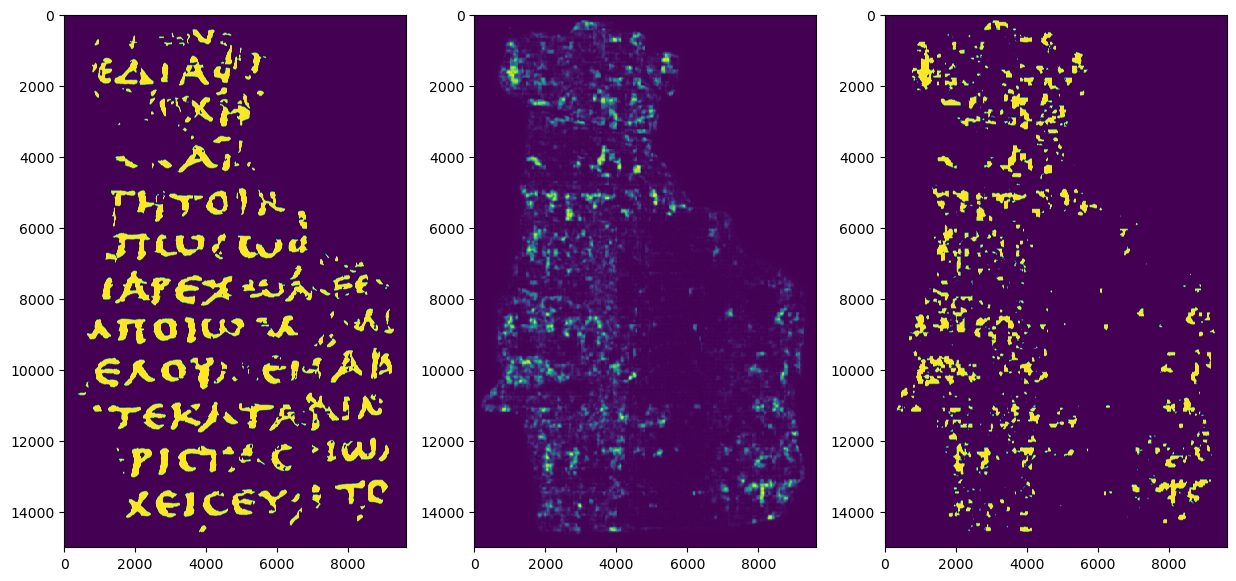

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.1795847e+08, 1.1045790e+07, 4.4127760e+06, 2.4662010e+06,
        1.7344990e+06, 1.3064910e+06, 9.9323400e+05, 8.1686100e+05,
        6.7579000e+05, 5.5355400e+05, 4.5493000e+05, 4.0296800e+05,
        3.4813800e+05, 3.0310500e+05, 2.8650500e+05, 2.5592800e+05,
        2.2168200e+05, 1.7751400e+05, 1.0853900e+05, 3.4081000e+04]),
 array([5.93790385e-10, 4.91177885e-02, 9.82355764e-02, 1.47353364e-01,
        1.96471152e-01, 2.45588940e-01, 2.94706728e-01, 3.43824516e-01,
        3.92942304e-01, 4.42060092e-01, 4.91177880e-01, 5.40295667e-01,
        5.89413455e-01, 6.38531243e-01, 6.87649031e-01, 7.36766819e-01,
        7.85884607e-01, 8.35002395e-01, 8.84120183e-01, 9.33237971e-01,
        9.82355759e-01]),
 <BarContainer object of 20 artists>)

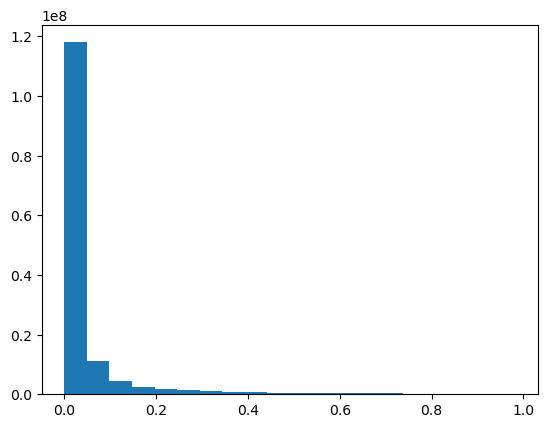

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000